***
***
# <center> Timeseries anomaly detection.


****


Below script demonstrates use of **keras**, one of the most popular Python libraries, it runs on TensorFlow and Theano. Mainly use for Deep Learning and focused on the idea of Models. 
<br>Below code will demonstrate example of using ***keras*** library to reconstruct convolutional autoencoder model for detecting anomalies in timeseries data.
<br>

***

Based on the website:

https://keras.io/examples/timeseries/timeseries_anomaly_detection/

Datasets used from keggle website:

https://www.kaggle.com/datasets/boltzmannbrain/nab


### <center> Datasets

Datasets used:
- art_daily_small_noise.csv 
- art_daily_jumpsup.csv 
<br>
Both datasets are available in form of csv files. Data are ordered, timestamped, with two columns of numeric data:
- **timestamp** - datetime data are stored in form, example: 2014-04-01 00:00:00
- **value** - numeric data in form of floating points, example: 20.500833
<br>
**Note:** some data from the column **value** differ from those from original dataset. Pandas rounding values till 6th place after coma. Above value in original dataset is 20.500833287.

<br>
In model is used Numenta Anomaly Benchmark(NAB) dataset. It provides artifical timeseries data containing labeled anomalous periods of behavior. 
<br>According to keggle website, The Numenta Anomaly Benchmark (NAB) is a novel benchmark for evaluating algorithms for anomaly detection in streaming, online applications. It is comprised of over 50 labeled real-world and artificial timeseries data files plus a novel scoring mechanism designed for real-time applications. 
<br>Some of available datasets are: AWS server metrics, online advertisement clicking rates, temperature sensor, real time traffic data and more.



More information and datasets is available on the NAB github page <br>https://github.com/numenta/NAB 

****

### <center>Import modules and load datasets.
***

In [1]:
# Numerical arrays.
import numpy as np

# Spread-sheet-like Data Frames.
import pandas as pd

# Neural networks.
import tensorflow.keras as keras

# Plotting.
import matplotlib.pyplot as plt

import matplotlib.animation as animation

In [2]:
# Get urls for datasets.
master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

# Dataset with anomaly.
with_anomaly_url = "artificialWithAnomaly/art_daily_jumpsup.csv"

# Dataset without anomaly.
no_anomaly_url = "artificialNoAnomaly/art_daily_small_noise.csv"

In [3]:
# Read csv dataset with anomaly from url by Pandas.
df_anomaly_url = master_url_root + with_anomaly_url
df_anomaly = pd.read_csv(df_anomaly_url, parse_dates=True, index_col="timestamp")

In [4]:
# Check url for dataset with anomaly art_daily_jumpsup.csv
df_anomaly_url

'https://raw.githubusercontent.com/numenta/NAB/master/data/artificialWithAnomaly/art_daily_jumpsup.csv'

In [5]:
# Check dataset.
df_anomaly.head()

,value
timestamp,
2014-04-01 00:00:00,19.761252
2014-04-01 00:05:00,20.500833
2014-04-01 00:10:00,19.961641
2014-04-01 00:15:00,21.490266
2014-04-01 00:20:00,20.187739


In [6]:
# Check size of dataset.
df_anomaly.shape

(4032, 1)

In [7]:
# Summary statistic for dataset with anomaly.
df_anomaly.describe()

,value
count,4032.000000
mean,44.494254
std,32.432473
min,18.001010
25%,19.991382
50%,21.648503
75%,76.435943
max,164.947481


In [8]:
# Read csv dataset without anomaly from url by Pandas.
df_no_anomaly_url = master_url_root + no_anomaly_url
df_no_anomaly = pd.read_csv(df_no_anomaly_url, parse_dates=True, index_col="timestamp")

In [9]:
# Check url for dataset without anomaly art_daily_small_noise.csv
df_no_anomaly_url

'https://raw.githubusercontent.com/numenta/NAB/master/data/artificialNoAnomaly/art_daily_small_noise.csv'

In [10]:
# Check dataset.
df_no_anomaly.head()

,value
timestamp,
2014-04-01 00:00:00,18.324919
2014-04-01 00:05:00,21.970327
2014-04-01 00:10:00,18.624806
2014-04-01 00:15:00,21.953684
2014-04-01 00:20:00,21.909120


In [11]:
# Check size of dataset.
df_no_anomaly.shape

(4032, 1)

In [12]:
# Summary statistic for dataset without anomaly.
df_no_anomaly.describe()

,value
count,4032.000000
mean,42.438353
std,28.077122
min,18.000964
25%,19.841390
50%,21.608487
75%,75.450282
max,87.976128


****

### <center> Visualize the data.
***

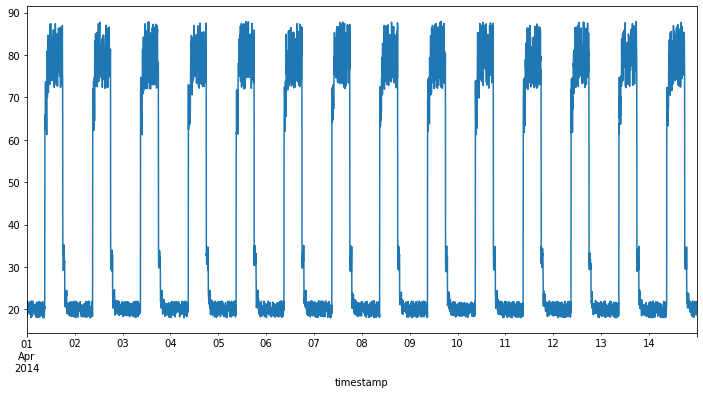

In [13]:
# Visualize the data - timeseries without anomalies.
fig, ax = plt.subplots(figsize=(12,6))

# Use Pandas to plot data frame.
df_no_anomaly.plot(legend=False, ax=ax);

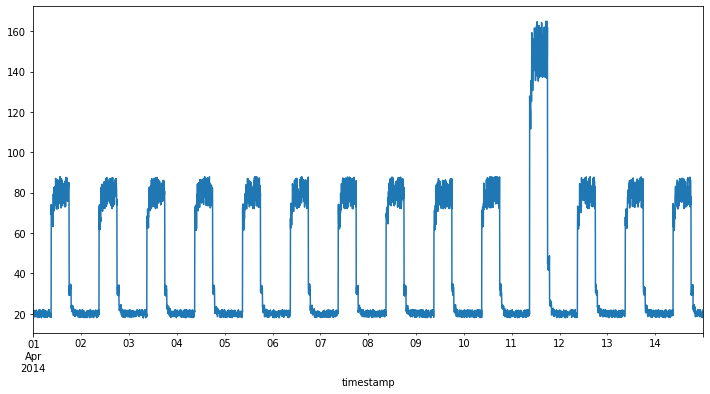

In [14]:
# Visualize the data - timeseries with anomalies.
fig, ax = plt.subplots(figsize=(12,6))

# Use Pandas to plot data frame.
df_anomaly.plot(legend=False, ax=ax);

### <center> Prepare training data.
***

According to the original script, to prepare data, values from the training timeseries should be normalized. 
Available values are for every 5 mins for 14 days.

    24 * 60 / 5 = 288     timesteps per day
    288 * 14 = 4032     data points in total


In [15]:
# Normalize and save the mean and std.
training_mean = df_no_anomaly.mean()
training_std = df_no_anomaly.std()

In [16]:
# Check the mean value.
print("Training mean is: ", training_mean)

Training mean is:  value    42.438353
dtype: float64


In [17]:
# Check the std value.
print("Training std is: ", training_std)

Training std is:  value    28.077122
dtype: float64


In [18]:
# Create training data.
df_train_vals = (df_no_anomaly - training_mean) / training_std

# Check training data.
df_train_vals.head()

,value
timestamp,
2014-04-01 00:00:00,-0.858829
2014-04-01 00:05:00,-0.728993
2014-04-01 00:10:00,-0.848148
2014-04-01 00:15:00,-0.729586
2014-04-01 00:20:00,-0.731173


In [19]:
# Check number of training data.
print("Number of training samples: ", df_train_vals.shape)

Number of training samples:  (4032, 1)


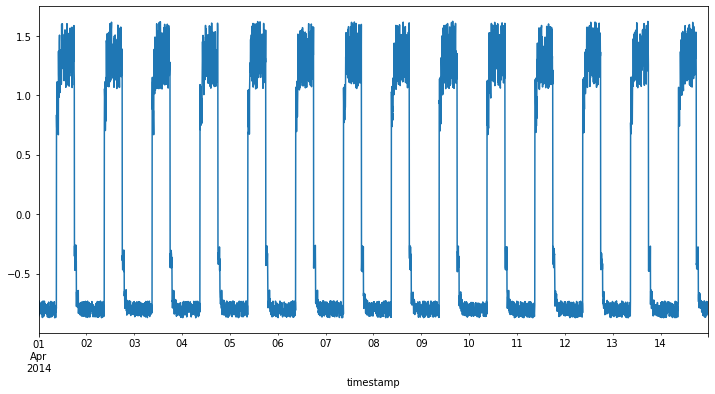

In [20]:
# Plot training data.
fig, ax = plt.subplots(figsize=(12,6))

# Use Pandas to plot data frame.
df_train_vals.plot(legend=False, ax=ax);

### <center> Create sequences.
***

To create sequences we will use functions:
 - windows() - create function to generate training sequences,
 - np.stack() - function that joins a sequence of arrays along a new axis, to create a window.
 
    Window example:
    
    ```python 
    [1,1,2,4,5,6,7,1,2,3,4,5]
    window_size = 3
    [1,1,2]
    [1,2,4]
    [2,4,5]
    [4,5,6]
    ...
    ```

In [21]:
# Window size.
window_size = 288

In [22]:
# Generated training sequences (window) for use in the model.
def windows(values, time_steps=window_size):
    # Create empty list.
    output = []
    # Loop trought the window.
    for i in range(len(values) - time_steps + 1):
        # Append window to the list.
        output.append(values[i : (i + time_steps)])
    # Create a 2D numpy array from windows.
    return np.stack(output)

In [23]:
# Call function to create trainning sequence.
x_train = windows(df_train_vals)

In [24]:
# Check training input shape.
x_train.shape

(3745, 288, 1)

In [25]:
# Check the x_train values (first and last).
x_train[0][0], x_train[0][-1]

(array([-0.85882857]), array([-0.79671155]))

Values from ***x_train*** set should have the same values as those in ***df_train_vals***. Which will prove that window is set correctly. 

In [26]:
# Check values from df_train_vals dataset (first and last).
df_train_vals.iloc[0], df_train_vals.iloc[window_size -1]

(value   -0.858829
 Name: 2014-04-01 00:00:00, dtype: float64,
 value   -0.796712
 Name: 2014-04-01 23:55:00, dtype: float64)

**Note:** values from x_train are differ from vales from df_train_vals, again they were rounded to 6th plase after coma. 

Lets plot window on the dataset, to check if it fits.

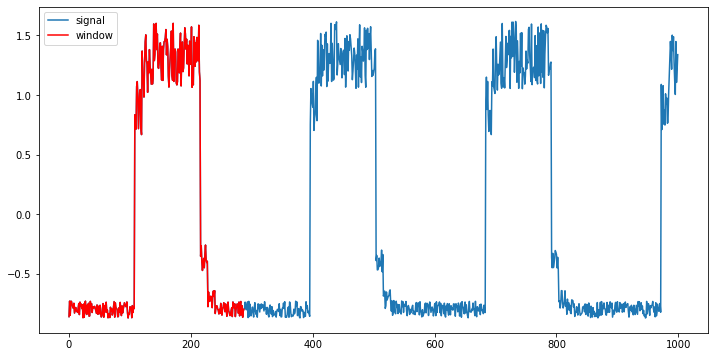

In [27]:
# Create a plot.
fig, ax = plt.subplots(figsize=(12,6))
# Define y values from first 1000 values from dataset.
y = df_train_vals['value'].values[:1000]
# Plot original data.
ax.plot(np.arange(y.shape[0]), y, label='signal')
# The first window, flatten into one dimension.
w = x_train[0].flatten()
# Plot window data on top of original data.
line = ax.plot(np.arange(w.shape[0]), w, 'r', label='window')
# Show legend.
ax.legend();

### <center>Build a model.
***

Model used here: a convolutional reconstruction autoencoder model.
According to the 

https://blog.keras.io/building-autoencoders-in-keras.html

"Autoencoding" is a data compression algorithm where the compression and decompression functions are 1) data-specific, 2) lossy, and 3) learned automatically from examples rather than engineered by a human. Additionally, in almost all contexts where the term "autoencoder" is used, the compression and decompression functions are implemented with neural networks.
To build an autoencoder, you need three things: an encoding function, a decoding function, and a distance function between the amount of information loss between the compressed representation of your data and the decompressed representation (i.e. a "loss" function).

Below we use sequential function to create a model. A Sequential model is appropriate for plain stock of layers when each layer has exactly one input tensor and one output tensor. Below model has seven layers passed as a list of layers. 

***But what those layers are?***
<br>
Leyers are the basic building blocks of neural networks in Keras. A layer consists of a tensor-in tensor-out computation function (the layer's call method) and some state, held in TensorFlow variables (the layer's weights). A layer instance is callable much like function, but unlike a  function, layers maintain a state , updated when the layer recieves data during training. 
<br>

There are few types of layers:
- core layers,
- convolution layers,
- pooling layers,
- recurrent layers,
- preprocessing layers,
- normalization layers,
- regularization layers
and much more. 

On purpose of our task we going to discuss only those used in code:
- Input - core layer - which will allow us to built a Keras model just by knowing the inputs and outputs of the model. 
- Conv1D and Conv1DTranspose - convolution layers,
- Dropout - regularization layer.


****
Below, is short desciption of layers and their methods:

 - ***Input*** - is used to instantiate a Keras tensor. 
       In below function there is only one argument used 
        --> shape - a shape tuple, for instance, shape=(32,) indicates that the expected input will be batches of 32-dimensional vectors. Elements of this tuple can be None; 'None' elements represent dimensions where the shape is not known.
        Other possible arguments: batch_size, name, dtype, sparce, tensor, ragged, type_spec. 
    Function returns a tensor.
      
      
 - ***Conv1D*** - It is 1D convolution layer. This layer creates a convolution kernel that is convolved with the layer input over a single spatial (or temporal) dimension to produce a tensor of outputs.
       Arguments used in function: 
         --> filters - Integer, the dimensionality of the output space (i.e. the number of output filters in the convolution). 
         --> kernel_size - An integer or tuple/list of a single integer, specifying the length of the 1D convolution window. 
         --> strides - An integer or tuple/list of a single integer, specifying the stride length of the convolution. 
         --> padding - One of "valid", "same" or "causal" (case-insensitive). "valid" means no padding. "same" results in padding with zeros evenly to the left/right or up/down of the input such that output has the same height/width dimension as the input. "causal" results in causal (dilated) convolutions.
        --> activation - Activation function to use. If you don't specify anything, no activation is applied.
        Other available arguments: data_format, dilation_rate, groups, use_bias, kernel_initializer, bias_initializer, kernel_regularizer, activity_regularizer, kernel_constraint, bias_constraint.
                

 - ***Dropout*** - The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged.
       Argument used in function:
         --> rate - Float between 0 and 1. Fraction of the input units to drop.
         Other available arguments: noise_shape, seed.

                 
 - ***Conv1DTranspose*** - The need for transposed convolutions generally arises from the desire to use a transformation going in the opposite direction of a normal convolution, i.e., from something that has the shape of the output of some convolution to something that has the shape of its input while maintaining a connectivity pattern that is compatible with said convolution.
       Arguments in function:
         --> filters - Integer, the dimensionality of the output space (i.e. the number of output filters in the convolution).
         --> kernel_size - An integer length of the 1D convolution window.
         --> strides - An integer specifying the stride of the convolution along the time dimension. Specifying a stride value != 1 is incompatible with specifying a dilation_rate value != 1. Defaults to 1.
         --> padding - one of "valid" or "same" (case-insensitive). "valid" means no padding. "same" results in padding with zeros evenly to the left/right or up/down of the input such that output has the same height/width dimension as the input.
         --> activation - Activation function to use. If you don't specify anything, no activation is applied (see keras.activations).
         Other available arguments: output_padding, data_format, dilation_rate, use_bias, kernel_initializer, bias_initializer, kernel_regularizer, bias_regularizer, activity_regularizer, kernel_constraint, bias_constraint.
 

       
More information about layers on: 
       https://keras.io/api/layers/
       
****

In [28]:
# Creating layers for keras.Sequential.
layers = [
    # Instantiate a keras tensor, one dimensional.
    keras.layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
    # Create a convolution kernel.
    keras.layers.Conv1D(
        filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),
    # Set input unit.
    keras.layers.Dropout(rate=0.2),
    # Create a convolution kernel.
    keras.layers.Conv1D(
        filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
    # Transpose layer.
    keras.layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
    # Set input unit.
    keras.layers.Dropout(rate=0.2),
    # Transpose layer.
    keras.layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),
    # Transpose layer.
    keras.layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]

In [29]:
# Create model.
model = keras.Sequential(layers)

Once the model is created, we can configure the model with losses and metrics with ***model.compile()*** and train the model with **model.fit()**.

***Compile*** method is used to configures the model for training. 
Arguments in function:
   - optimizer - String (name of optimizer) or optimizer instance. Keras.optimizer is build-in optimizer classes. Optimizer used below implements ***the Adam algorithm*** (keras.optimizers.Adam). Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments. Argument used in this case is "learning_rate" - A tf.Tensor, floating point value, a schedule that is a tf.keras.optimizers.schedules.LearningRateSchedule, or a callable that takes no arguments and returns the actual value to use. The learning rate. Defaults to 0.001. 
   - loss - Loss function, may be a string (name of loss function), or a tf.keras.losses.Loss instance. A loss function is any callable with the signature loss = fn(y_true, y_pred), where y_true are the ground truth values, and y_pred are the model's predictions. The loss function should return a float tensor. If the model has multiple outputs, you can use a different loss on each output by passing a dictionary or a list of losses. The loss value that will be minimized by the model will then be the sum of all individual losses, unless loss_weights is specified.
      Other available arguments: metrics, loss_weights, weighted_metrics, run_eagerly, steps_per_execution, jit_compile.
              

In [30]:
# Set optimizer.
optimizer = keras.optimizers.Adam(learning_rate=0.001)

In [31]:
# Compile the model. 
model.compile(optimizer=optimizer, loss="mse")

In [32]:
# Print summary of the model. 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 144, 32)           256       
_________________________________________________________________
dropout (Dropout)            (None, 144, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 72, 16)            3600      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 144, 16)           1808      
_________________________________________________________________
dropout_1 (Dropout)          (None, 144, 16)           0         
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 288, 32)           3616      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 288, 1)            2

### Train the model.
***

NOTE: in this model ***x_train*** is used both as a input and the target - since this is a reconstruction model.

Method used on the model is ***fit***  which will train the model for a fixed number of epochs (iterations on a dataset).
Arguments used: 
- input_data - dataset used for model, can be Numpy array, Tensorflow tensor.
- target_data - Like the input data, it could be either Numpy array or TensorFlow tensor, It should be consistent with input_data.
- epochs -  number of epochs to train the model. An epoch is an iteration over the entire x and y datasets provided.
- batch_size -  number of samples per gradient update.
- validation_split - float between 0 and 1. Fraction of the training data to be used as validation data. The model will set apart this fraction of the training data, will not train on it, and will evaluate the loss and any model metrics on this data at the end of each epoch.
- callbacks - list of keras.callbacks.Callback instances. List of callbacks to apply during training.


***Model.fit*** is returning a History object, its History.history attribute is a record of training loss values and metrics values at successive epochs, as well as validation loss values and validation metrics values (if applicable).

In [33]:
# Modeling data
history = model.fit(
    # Passing both input and output as same train data.
    x_train,
    x_train,
    # Set number of iteration.
    epochs=50,
    # Number of samples.
    batch_size=128,
    # Set size of validation data.
    validation_split=0.1,
    # List of callbacks.
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")],
)

Epoch 1/50
27/27 [==============================] - 1s 46ms/step - loss: 0.4909 - val_loss: 0.1049
Epoch 2/50
27/27 [==============================] - 1s 35ms/step - loss: 0.0794 - val_loss: 0.0427
Epoch 3/50
27/27 [==============================] - 1s 35ms/step - loss: 0.0594 - val_loss: 0.0377
Epoch 4/50
27/27 [==============================] - 1s 37ms/step - loss: 0.0494 - val_loss: 0.0319
Epoch 5/50
27/27 [==============================] - 1s 37ms/step - loss: 0.0420 - val_loss: 0.0301
Epoch 6/50
27/27 [==============================] - 1s 37ms/step - loss: 0.0375 - val_loss: 0.0276
Epoch 7/50
27/27 [==============================] - 1s 36ms/step - loss: 0.0337 - val_loss: 0.0263
Epoch 8/50
27/27 [==============================] - 1s 37ms/step - loss: 0.0305 - val_loss: 0.0246
Epoch 9/50
27/27 [==============================] - 1s 39ms/step - loss: 0.0280 - val_loss: 0.0242
Epoch 10/50
27/27 [==============================] - 1s 37ms/step - loss: 0.0261 - val_loss: 0.0250
Epoch 11/

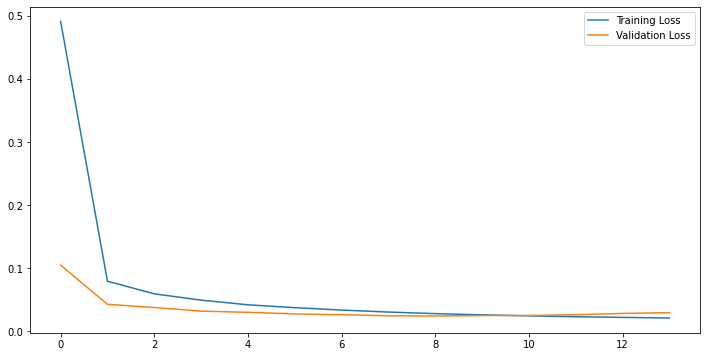

In [34]:
# Plot training and validation loss.
fig, ax = plt.subplots(figsize=(12,6))
# Plot training loss.
plt.plot(history.history["loss"], label="Training Loss")
# Plot validation loss.
plt.plot(history.history["val_loss"], label="Validation Loss")
# Show legend.
plt.legend();

****

### Detecting anomalies.

We will detect anomalies by determining how well our model can reconstruct the input data. One of the steps included in that process, is finding **MAE loss**, which I belive is count of **Mean Absolute Error**, and maximum value of it. This is the worst our model has performed trying to reconstruct a sample. And it will become the **threshold** for anomaly detection.
<br>If the reconstruction loss for a sample is greater than this threshold value then it can be And that can be labeled as an **anomaly**.


<br> First method **predict** will be used, to get the prediction of the trained model. Predict helps in strategizing and finalizing the entire model with proper filters, including class labels and regression predictors. Below we used just one argument which is input sample, in this case is a ***x_train*** - sequence created above by the windows function.

In [35]:
# Generate output predictions for input dataset.
x_train_pred = model.predict(x_train)

In [36]:
# Calculate MAE loss.
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

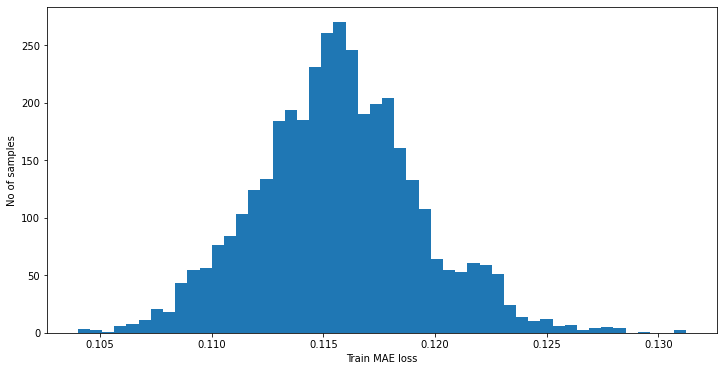

In [37]:
# Plot train loss data.
fig, ax = plt.subplots(figsize=(12,6))
# Plot histogram.
ax.hist(train_mae_loss, bins=50)
# Name label for x axis.
ax.set_xlabel("Train MAE loss")
# Name label for y axis.
ax.set_ylabel("No of samples");

In [38]:
# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print( threshold)

0.1312572159283987


****

### Compare reconstructions.

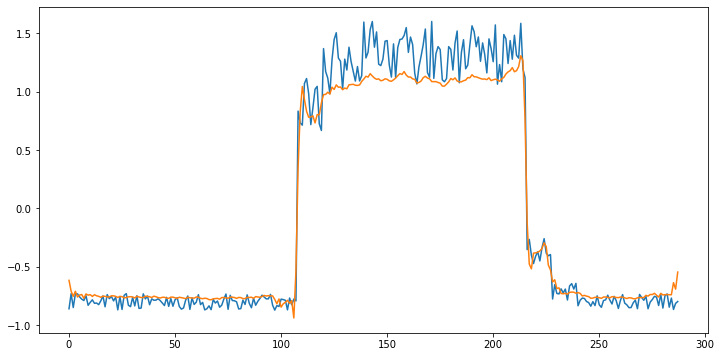

In [39]:
# Checking how the first sequence is learnt.
# Plot data.
fig, ax = plt.subplots(figsize=(12,6))
# Plot train data.
ax.plot(x_train[0])
# Plot predicted data.
ax.plot(x_train_pred[0]);

#### Prepare test data

In [40]:
# Use test mean and test std on test value.
df_test_value = (df_anomaly - training_mean) / training_std

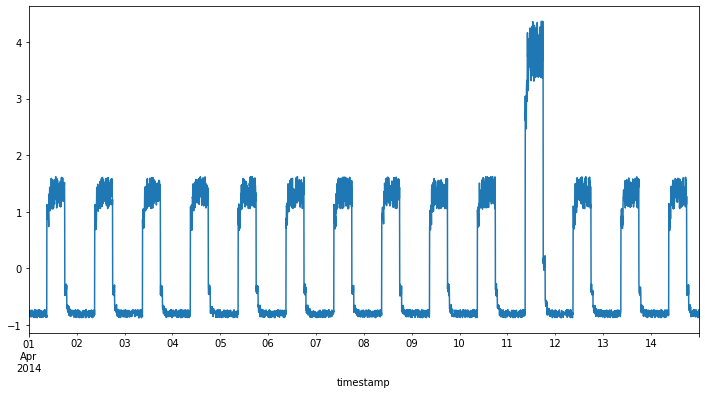

In [41]:
# Plot test data.
fig, ax = plt.subplots(figsize=(12,6))

# Use Pandas to plot data frame.
df_test_value.plot(legend=False, ax=ax);

In [42]:
# Create sequences from test values.
x_test = windows(df_test_value.values)

x_test.shape

(3745, 288, 1)

In [44]:
# Generate output predictions for input dataset.
x_test_pred = model.predict(x_test)

In [45]:
# Check array of predictions.
x_test_pred[0][:3]

array([[-0.61230004],
       [-0.70502704],
       [-0.75536823]], dtype=float32)

In [46]:
# Get test MAE loss.
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)

In [47]:
test_mae_loss

array([[0.11417703],
       [0.1159114 ],
       [0.11609092],
       ...,
       [0.11671869],
       [0.11650615],
       [0.1149248 ]])

In [48]:
test_mae_loss

array([[0.11417703],
       [0.1159114 ],
       [0.11609092],
       ...,
       [0.11671869],
       [0.11650615],
       [0.1149248 ]])

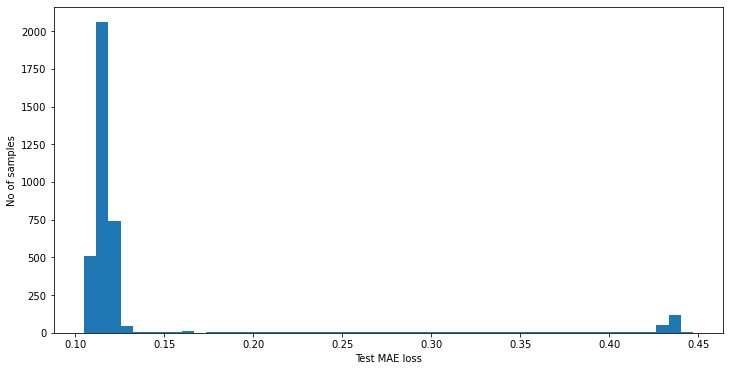

In [49]:
# Set the plot
fig, ax = plt.subplots(figsize=(12,6))
# Plot histogram.
ax.hist(test_mae_loss, bins=50)
# Set x-axis label.
ax.set_xlabel("Test MAE loss")
# Set y-axis label.
ax.set_ylabel("No of samples");

In [50]:
# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold

# Number of anomalies.
np.sum(anomalies)

399

In [51]:
# Indices of anomalies.
np.where(anomalies)

(array([ 789,  790, 1654, 2518, 2697, 2702, 2703, 2704, 2705, 2706, 2707,
        2708, 2709, 2710, 2711, 2712, 2713, 2714, 2715, 2716, 2717, 2718,
        2719, 2720, 2721, 2722, 2723, 2724, 2725, 2726, 2727, 2728, 2729,
        2730, 2731, 2732, 2733, 2734, 2735, 2736, 2737, 2738, 2739, 2740,
        2741, 2742, 2743, 2744, 2745, 2746, 2747, 2748, 2749, 2750, 2751,
        2752, 2753, 2754, 2755, 2756, 2757, 2758, 2759, 2760, 2761, 2762,
        2763, 2764, 2765, 2766, 2767, 2768, 2769, 2770, 2771, 2772, 2773,
        2774, 2775, 2776, 2777, 2778, 2779, 2780, 2781, 2782, 2783, 2784,
        2785, 2786, 2787, 2788, 2789, 2790, 2791, 2792, 2793, 2794, 2795,
        2796, 2797, 2798, 2799, 2800, 2801, 2802, 2803, 2804, 2805, 2806,
        2807, 2808, 2809, 2810, 2811, 2812, 2813, 2814, 2815, 2816, 2817,
        2818, 2819, 2820, 2821, 2822, 2823, 2824, 2825, 2826, 2827, 2828,
        2829, 2830, 2831, 2832, 2833, 2834, 2835, 2836, 2837, 2838, 2839,
        2840, 2841, 2842, 2843, 2844, 

### Plot anomalies

In [52]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
inds = []
for i in range(window_size - 1, len(df_test_value) - window_size + 1):
    if np.all(anomalies[i - window_size + 1 : i]):
        inds.append(i)


In [53]:
#inds

In [54]:
#
df_subset = df_anomaly.iloc[inds]

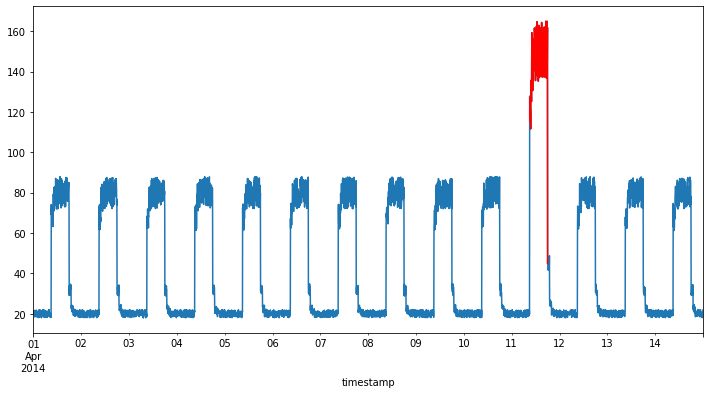

In [55]:
# Plot 
fig, ax = plt.subplots(figsize=(12,6))

# Plot dataset.
df_anomaly.plot(legend=False, ax=ax)
# Plot anomaly.
df_subset.plot(legend=False, ax=ax, color="r");

*****
*****